In [1]:
# import
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
import math
import time
import os

In [2]:
from sklearn import datasets
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier

In [3]:
# read file
def read_file(fname, delimiter=None, converters=None):
    data = np.loadtxt(fname, delimiter=delimiter, converters=converters)
    return data

In [4]:
def label(s):
    if s == 'Iris-setosa':
        return 1.
    elif s == 'Iris-versicolor':
        return 2.
    else:
        return 3.

In [5]:
# K_Fold
def K_Fold(n, n_folds=5, shuffle=False):
    step = n // n_folds
    remainder = n % n_folds
    
    # generate fold sizes
    fold_sizes = (step) * np.ones(n_folds, dtype=np.int)
    fold_sizes[:remainder] += 1
    
    train_idx = []
    test_idx = []
    
    sequence = np.array(range(n))
    if shuffle:
        np.random.shuffle(sequence)
        
    cursor = 0
    for fs in fold_sizes:
        test_fold = sequence[cursor:cursor + fs]
        test_idx.append(test_fold)
        train_fold = np.delete(sequence, range(cursor, cursor + fs))
        train_idx.append(train_fold)
        cursor += fs
        
    return train_idx, test_idx

In [6]:
# fit transform
def fit_transform(X, degree):
    Z = np.insert(X, 0, 1, axis=1)
    if degree > 1:
        for i in range(2, degree + 1):
            Z = np.append(Z, X ** i, axis=1)
    return Z

In [7]:
# fit
def fit(X, y, j, alpha, epsilon):
    return stochastic_gradient_descent(X, y, j, alpha, epsilon)

In [8]:
# stochastic gradient descent
def stochastic_gradient_descent(X, y, j, alpha, epsilon):
    y_indicator = indicator(y, j)
    X_i = np.transpose(np.expand_dims(X[0], axis=0)) # (n + 1, 1)
    y_i = np.expand_dims(y_indicator[0], axis=0) # (1, 1)
    
    # init theta with random number / all zeros / all ones
    # theta_1 = (0.1 ** 10) * np.random.randn(X.shape[1], 1)
    theta_1 = np.zeros((X.shape[1], 1))
    # theta_1 = np.ones((X.shape[1], 1))
    
    if X.shape[0] == 0:
        return theta_1
    
    suc_flag = False
    
    while not suc_flag:
        for i in range(X.shape[0]):
            X_i = np.transpose(np.expand_dims(X[i], axis=0)) # (n + 1, 1)
            y_i = np.expand_dims(y_indicator[i], axis=0) # (1, 1)
            
            theta_0 = np.copy(theta_1)
            h_0 = sigmoid(X_i, theta_0)
            l_0 = cost(h_0, y_i)

            theta_1 = theta_0 - alpha * np.dot(X_i, np.transpose((h_0 - y_i)))
            
            h_1 = sigmoid(X_i, theta_1)
            l_1 = cost(h_1, y_i)

            if np.fabs(l_1 - l_0) <= epsilon:
                suc_flag = True
                break
                
    return theta_1

In [9]:
# sigmoid
# X: (n + 1, m)
# theta: (n + 1, k)
# return: (k, m)
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-np.dot(theta.T, X)))

In [10]:
# cost
# h: (m, 1)
# y: (m, 1)
# return: scalar
def cost(h, y):
    return -1. * np.sum(y * np.log(h) - (1. - y) * np.log(1. - h))

In [11]:
# inidicator(y == i)
def indicator(y, i):
    return ((y == i) + 0)

In [12]:
# g(x)
# return: (X.shape[0], k)
def g(X, theta):
    return np.dot(X, theta)

In [13]:
# predict
def predict(X, theta):
    gs = g(X, theta)
    y = np.argmax(gs, axis=1)
    return y

In [14]:
# score
def score(X, y, k):
    c_matrix = np.zeros((k, k))
    for j in range(X.shape[0]):
        c_matrix[int(X[j])][int(y[j])] += 1
    
    accuracy = 1. * np.sum(c_matrix[i][i] for i in range(c_matrix.shape[0])) / np.sum(c_matrix)
    return c_matrix, accuracy

In [15]:
# cross validation
def cross_validation(X, y, degree, k, alpha, epsilon, n_folds=5, r_verbose=False):
    train_c_matrix = []
    train_accuracy = []
    
    test_c_matrix = []
    test_accuracy = []
    
    Z = fit_transform(X, degree)
    train_idx, test_idx = K_Fold(y.shape[0], n_folds=n_folds, shuffle=True)
    
    for i in range(n_folds):
        theta = np.zeros((Z.shape[1], 1))
        
        # fit
        for j in range(k):
            # fit
            theta_j = fit(Z[train_idx[i]], y[train_idx[i]], j, \
                          alpha=alpha, epsilon=epsilon)
            theta = np.append(theta, theta_j, axis=1)
        
        # after deleting the column 0, theta is in shape n * k, column i is theta_i for class i (0 <= i <= k-1)
        theta = np.delete(theta, 0, axis=1)
        
        # training error
        train_predicted = predict(Z[train_idx[i]], theta)
        tr_c_matrix, tr_accuracy = score(train_predicted, y[train_idx[i]], k)

        # test error
        test_predicted = predict(Z[test_idx[i]], theta)
        t_c_matrix, t_accuracy = score(test_predicted, y[test_idx[i]], k)
        
        train_c_matrix.append(tr_c_matrix)
        train_accuracy.append(tr_accuracy)
        
        test_c_matrix.append(t_c_matrix)
        test_accuracy.append(t_accuracy)
        
    # average error
    train_accuracy_avg = np.mean(train_accuracy)
    
    test_accuracy_avg = np.mean(test_accuracy)

    if r_verbose:
        print '(average results) CROSS_VALIDATION (degree = %d) (k = %d) (n_folds = %d):' % (degree, k, n_folds)
        print 'train_c_matrix, train_accuracy_avg'
        for i in range(len(train_c_matrix)):
            print train_c_matrix[i]
        print train_accuracy_avg
        print '\n'
        print 'test_c_matrix, test_accuracy_avg'
        for i in range(len(test_c_matrix)):
            print test_c_matrix[i]
        print test_accuracy_avg
        print '\n'

# 1 (a) 2-class Logistic Regression

In [16]:
print(__doc__)

# read file
fname = 'iris.data'
data = read_file(fname, delimiter=',', converters={4: label})
s = np.split(data, [data.shape[1] - 1], axis=1)
X = s[0][50:150]
y = s[1][50:150] - 2.

degree = 0
k = 2
alpha = 0.001
epsilon = 0.0001
n_folds = 5
r_verbose = True

# start timing
start = time.time()

# cross validation
cross_validation(X, y, degree, k, alpha, epsilon, n_folds=n_folds, r_verbose=r_verbose)

# stop timing
stop = time.time()
duration = stop - start

print 'duration =', duration

Automatically created module for IPython interactive environment
(average results) CROSS_VALIDATION (degree = 0) (k = 2) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 34.   0.]
 [  4.  42.]]
[[ 42.   0.]
 [  2.  36.]]
[[ 35.   0.]
 [  3.  42.]]
[[ 37.   0.]
 [  3.  40.]]
[[ 37.   0.]
 [  3.  40.]]
0.9625


test_c_matrix, test_accuracy_avg
[[ 12.   0.]
 [  0.   8.]]
[[  6.   0.]
 [  0.  14.]]
[[ 11.   0.]
 [  1.   8.]]
[[  8.   0.]
 [  2.  10.]]
[[  9.   0.]
 [  1.  10.]]
0.96


duration = 10.8072888851


# 1 (b)  2-class Logistic Regression with non-linear combination

In [17]:
# read file
fname = 'iris.data'
data = read_file(fname, delimiter=',', converters={4: label})
s = np.split(data, [data.shape[1] - 1], axis=1)
X = s[0][50:150]
y = s[1][50:150] - 2.

degree = 2
k = 2
alpha = 0.001
epsilon = 0.0001
n_folds = 5
r_verbose = True

# start timing
start = time.time()

# cross validation
cross_validation(X, y, degree, k, alpha, epsilon, n_folds=n_folds, r_verbose=r_verbose)

# stop timing
stop = time.time()
duration = stop - start

print 'duration =', duration

(average results) CROSS_VALIDATION (degree = 2) (k = 2) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 32.   1.]
 [  6.  41.]]
[[ 34.   1.]
 [  4.  41.]]
[[ 36.   1.]
 [  6.  37.]]
[[ 43.  19.]
 [  0.  18.]]
[[ 33.   1.]
 [  6.  40.]]
0.8875


test_c_matrix, test_accuracy_avg
[[ 11.   0.]
 [  1.   8.]]
[[ 9.  0.]
 [ 3.  8.]]
[[  7.   0.]
 [  1.  12.]]
[[ 7.  7.]
 [ 0.  6.]]
[[ 10.   0.]
 [  1.   9.]]
0.87


duration = 0.25905418396


# 1 (c) k-class Logistic Regression

In [18]:
# read file
fname = 'iris.data'
data = read_file(fname, delimiter=',', converters={4: label})
s = np.split(data, [data.shape[1] - 1], axis=1)
X = s[0]
y = s[1] - 1.

degree = 0
k = 3
alpha = 0.001
epsilon = 0.0001
n_folds = 5
r_verbose = True

# start timing
start = time.time()

# cross validation
cross_validation(X, y, degree, k, alpha, epsilon, n_folds=n_folds, r_verbose=r_verbose)

# stop timing
stop = time.time()
duration = stop - start

print 'duration =', duration

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 43.   0.   0.]
 [  0.  27.   8.]
 [  0.  13.  29.]]
[[ 40.   0.   0.]
 [  0.  23.   4.]
 [  0.  17.  36.]]
[[ 37.   0.   0.]
 [  0.  31.   8.]
 [  0.  12.  32.]]
[[ 39.   0.   0.]
 [  0.  30.   5.]
 [  0.  12.  34.]]
[[ 41.   0.   0.]
 [  0.   9.   0.]
 [  0.  26.  44.]]
0.825


test_c_matrix, test_accuracy_avg
[[  7.   0.   0.]
 [  0.   3.   1.]
 [  0.   7.  12.]]
[[ 10.   0.   0.]
 [  0.   3.   1.]
 [  0.   7.   9.]]
[[ 13.   0.   0.]
 [  0.   6.   1.]
 [  0.   1.   9.]]
[[ 11.   0.   0.]
 [  0.   8.   6.]
 [  0.   0.   5.]]
[[  9.   0.   0.]
 [  0.   3.   0.]
 [  0.  12.   6.]]
0.76


duration = 16.0240461826


# 2 (b) Two layer feedback MLP for 3-class classification

In [16]:
# fit2
def fit2(X, y, k, h, alpha, epsilon, max_iter=5):
    return stochastic_gradient_descent2(X, y, k, h, alpha, epsilon, max_iter=max_iter)

In [29]:
# stochastic gradient descent
def stochastic_gradient_descent2(X, y, k, h, alpha, epsilon, max_iter=5):
#     X_i = np.transpose(np.expand_dims(X[0], axis=0)) # (n + 1, 1)
#     y_i = np.expand_dims(y[0], axis=0) # scalar
    
    # init W and V with random number / all zeros / all ones
    
    # V: shape (h + 1, k)
    # V_1 = 1e-3 * np.random.randn(h + 1, k)
    V_1 = np.ones((h + 1, k)) * (math.sqrt(6) / (y.shape[0] + k))
    # V_1 = np.zeros((h + 1, k))
    # V_1 = np.ones((h + 1, k))
    
    # W: shape (n + 1, h)
    # W_1 = 1e-3 * np.random.randn(X.shape[1], h)
    W_1 = np.ones((X.shape[1], h)) * (np.sqrt(6) / (y.shape[0] + k))
    # W_1 = np.zeros((X.shape[1], h))
    # W_1 = np.ones((X.shape[1], h))
    
    if X.shape[0] == 0:
        return V_1, W_1
    
    suc_flag = False
    l = []
    count = 0
    
    while not suc_flag:
        count += 1
        if count > max_iter:
            suc_flag = True
            break
                
        for i in range(X.shape[0]):
            X_i = np.transpose(np.expand_dims(X[i], axis=0)) # (n + 1, 1)
            y_i = np.expand_dims(y[i], axis=0) # scalar
            
            V_0 = np.copy(V_1) # (h + 1, k)
            W_0 = np.copy(W_1) # (n + 1, h)
            
            # use W_0 and V_0 to get z_0 and y_hat_0
            z_0 = sigmoid(X_i, W_0) # (h, 1)
            z_input_0 = np.transpose(fit_transform(z_0.T, 0))
            y_hat_0 = sigmoid(z_input_0, V_0) # (k, 1)
            l_0 = cost2(y_hat_0, y_i) # (1, 1)
            l.append(l_0)

            V_1 = V_0 - alpha * np.dot(z_input_0, np.transpose(y_hat_0 - indicator2(y_i, k))) # (h + 1, k)
            W_1 = W_0 - alpha * np.dot(\
                                       X_i, \
                                       np.dot(\
                                              np.dot(\
                                                     np.dot(\
                                                            z_0.T, \
                                                            V_0[1:h + 1]\
                                                           ), \
                                                     (y_hat_0 - indicator2(y_i, k))\
                                                    ), \
                                              np.transpose(1. - z_0)\
                                             )\
                                      )
            
            z_1 = sigmoid(X_i, W_1)
            z_input_1 = np.transpose(fit_transform(z_1.T, 0))
            y_hat_1 = sigmoid(z_input_1, V_1)
            l_1 = cost2(y_hat_1, y_i)

#             if np.fabs(l_1 - l_0) <= epsilon:
#                 suc_flag = True
#                 break
    
    plt.plot(range(len(l)), l, 'ro-')
    plt.title('Objective - iteration times (alpha = %f)' % alpha)
    plt.xlabel('iteration times')
    plt.ylabel('objective')
    plt.show()
    
    return V_1, W_1

In [18]:
# indicator2
# return (k, 1)
def indicator2(y, k):
    y_indicator = np.zeros((k, 1))
    y_indicator[int(y)] = 1
    return y_indicator

In [19]:
# predict
def predict2(X, V, W):
    y = np.argmax(np.transpose(sigmoid(np.transpose(fit_transform(np.transpose(sigmoid(X.T, W)), 0)), V)), axis=1)
    return y

In [20]:
# cost
# y_hat: (k, 1)
# y: (m, 1)
# return: scalar
def cost2(y_hat, y):
    l = 0.
    for j in range(y_hat.shape[0]):
        l += np.sum(indicator(y, j) * np.log(y_hat[j]))
    return -l

In [21]:
# cross validation
def cross_validation2(X, y, degree, k, h, alpha, epsilon, truncate=0.0, n_folds=5, max_iter=5, r_verbose=False):
    train_c_matrix = []
    train_accuracy = []
    
    test_c_matrix = []
    test_accuracy = []
    
    Z = fit_transform(X, degree)
    train_idx, test_idx = K_Fold(y.shape[0], n_folds=n_folds, shuffle=True)
    
    for i in range(1):
        if truncate > 0.0 and truncate < 1.0:
            remain_amount = int(math.ceil(len(X) * truncate))
            X_train = Z[train_idx[i]][:remain_amount]
            y_train = y[train_idx[i]][:remain_amount]
            X_test = Z[test_idx[i]][:remain_amount]
            y_test = y[test_idx[i]][:remain_amount]
        
        # fit
        V, W = fit2(X_train, y_train, k, h, max_iter=max_iter, \
                   alpha=alpha, epsilon=epsilon)
        
        # training error
        train_predicted = predict2(X_train, V, W)
        tr_c_matrix, tr_accuracy = score(train_predicted, y_train, k)

        # test error
        test_predicted = predict2(X_test, V, W)
        t_c_matrix, t_accuracy = score(test_predicted, y_test, k)
        
        train_c_matrix.append(tr_c_matrix)
        train_accuracy.append(tr_accuracy)
        
        test_c_matrix.append(t_c_matrix)
        test_accuracy.append(t_accuracy)
        
    # average error
    train_accuracy_avg = np.mean(train_accuracy)
    
    test_accuracy_avg = np.mean(test_accuracy)

    if r_verbose:
        print '(average results) CROSS_VALIDATION (degree = %d) (k = %d) (n_folds = %d):' % (degree, k, n_folds)
        print 'train_c_matrix, train_accuracy_avg'
        for i in range(len(train_c_matrix)):
            print train_c_matrix[i]
        print train_accuracy_avg
        print '\n'
        print 'test_c_matrix, test_accuracy_avg'
        for i in range(len(test_c_matrix)):
            print test_c_matrix[i]
        print test_accuracy_avg
        print '\n'
        
    return train_accuracy_avg, test_accuracy_avg

(21770, 784)
(21770, 1)
[ 0.  1.  2.]


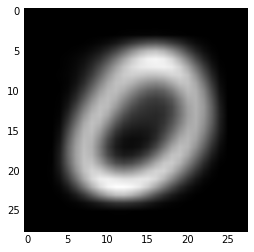

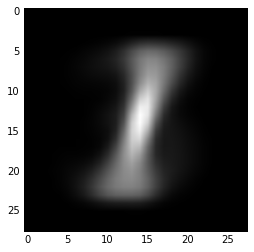

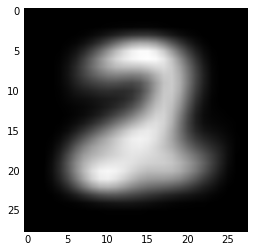

In [22]:
# read data
mnist = fetch_mldata('MNIST original')
X_all = mnist.data / 255. # (70000, 784)
y_all = mnist.target # (70000, 1)

y = np.expand_dims(y_all[y_all <= 2], axis=1)
X = X_all[:y.shape[0]]
print X.shape
print y.shape
print np.unique(y)

# extract "3" digits and show their average"
for i in range(3):
    ind = [k for k in range(len(y)) if y[k] == i]
    extracted_images = X[ind, : ]

    mean_image = extracted_images.mean(axis=0)
    imshow(mean_image.reshape(28, 28), cmap=cm.gray)
    show()

alpha = 0.001


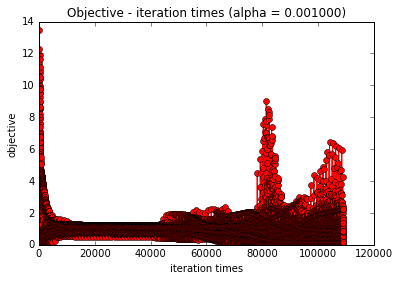

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 288.    0.   37.]
 [   4.  245.   11.]
 [  71.  149.  284.]]
0.750229568411


test_c_matrix, test_accuracy_avg
[[ 270.    0.   39.]
 [   2.  259.   12.]
 [  76.  154.  277.]]
0.74012855831


duration = 69.2374048233
alpha = 0.005


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


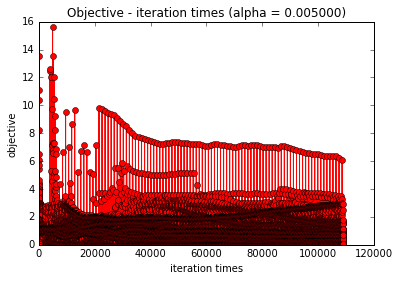

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 291.  203.   27.]
 [  47.  158.   50.]
 [   4.    8.  301.]]
0.68870523416


test_c_matrix, test_accuracy_avg
[[ 274.  241.   26.]
 [  31.  155.   66.]
 [  15.   23.  258.]]
0.63085399449


duration = 70.290997982
alpha = 0.01


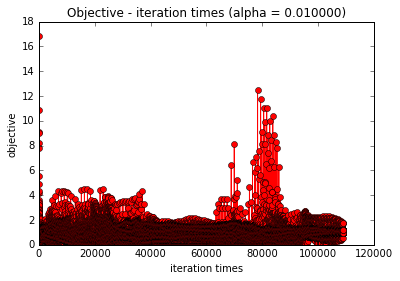

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[   0.    0.    0.]
 [ 330.  374.  328.]
 [  11.   27.   19.]]
0.3608815427


test_c_matrix, test_accuracy_avg
[[   0.    0.    0.]
 [ 347.  377.  318.]
 [   6.   30.   11.]]
0.356290174472


duration = 69.4807958603
alpha = 0.05


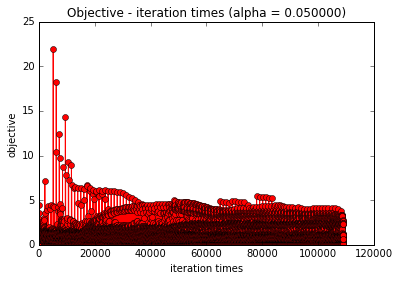

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[  82.   52.    2.]
 [ 244.  316.   68.]
 [  13.   22.  290.]]
0.631772268136


test_c_matrix, test_accuracy_avg
[[  75.   69.    3.]
 [ 247.  302.   78.]
 [  22.   37.  256.]]
0.581267217631


duration = 70.312210083
alpha = 0.1


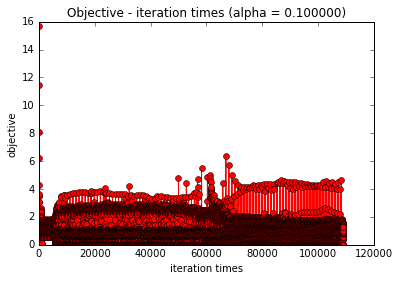

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 335.  208.  325.]
 [   0.  173.    3.]
 [   2.   12.   31.]]
0.494949494949


test_c_matrix, test_accuracy_avg
[[ 320.  196.  321.]
 [   0.  200.    4.]
 [   4.    9.   35.]]
0.509641873278


duration = 69.9976508617
alpha = 0.5


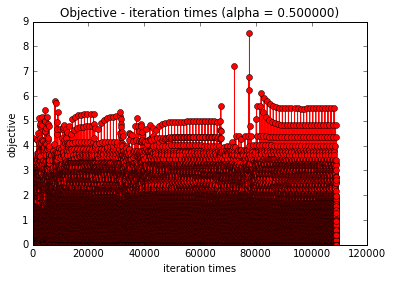

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 301.    0.    2.]
 [   0.  109.    0.]
 [  49.  288.  340.]]
0.68870523416


test_c_matrix, test_accuracy_avg
[[ 266.    1.   10.]
 [   0.  106.    0.]
 [  43.  327.  336.]]
0.650137741047


duration = 71.4320700169


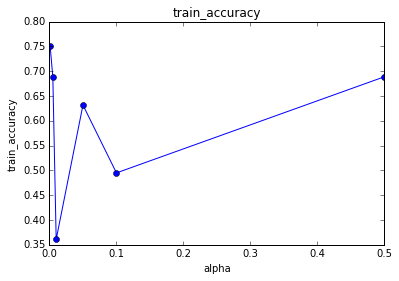

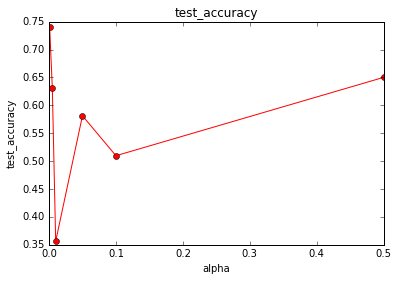

In [34]:
# V_1 = np.random.randn(h + 1, k)
# W_1 = np.random.randn(X.shape[1], h)

degree = 0
k = 3
h = 150
alpha = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
epsilon = 0
truncate = 0.05
n_folds = 5
max_iter = 100
r_verbose = True

train_accuracy = []
test_accuracy = []

for a in alpha:
    print 'alpha =', a
    # start timing
    start = time.time()

    # cross validation
    tr_accuracy, t_accuracy = cross_validation2(X, y, degree, k, h, a, epsilon, \
                                                truncate=truncate, n_folds=n_folds, \
                                                max_iter=max_iter, r_verbose=r_verbose)
    
    # stop timing
    stop = time.time()
    duration = stop - start
    
    train_accuracy.append(tr_accuracy)
    test_accuracy.append(t_accuracy)

    print 'duration =', duration

plt.plot(alpha, train_accuracy, 'bo-')
plt.title('train_accuracy')
plt.xlabel('alpha')
plt.ylabel('train_accuracy')
plt.show()

plt.plot(alpha, test_accuracy, 'ro-')
plt.title('test_accuracy')
plt.xlabel('alpha')
plt.ylabel('test_accuracy')
plt.show()

h =  50


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


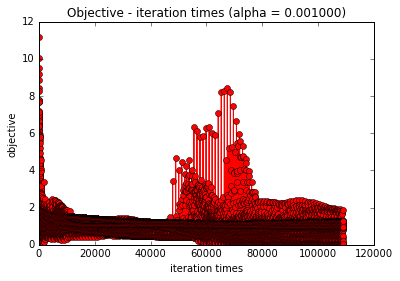

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[  82.   23.    0.]
 [ 289.  354.  315.]
 [   1.    4.   21.]]
0.419651056015


test_c_matrix, test_accuracy_avg
[[  71.   17.    0.]
 [ 271.  342.  347.]
 [   2.    8.   31.]]
0.407713498623


duration = 33.6097450256
h =  150


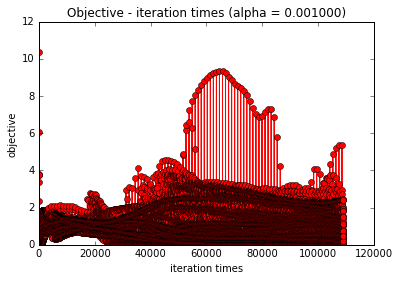

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 326.   80.  126.]
 [  12.  335.    9.]
 [   7.    0.  194.]]
0.785123966942


test_c_matrix, test_accuracy_avg
[[ 313.  100.  126.]
 [  15.  305.   16.]
 [  13.    1.  200.]]
0.751147842057


duration = 67.8342649937
h =  250


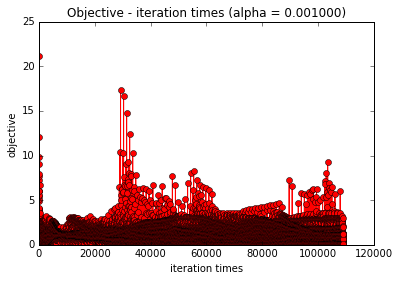

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 258.    0.    1.]
 [  37.  361.  121.]
 [  70.    9.  232.]]
0.78145087236


test_c_matrix, test_accuracy_avg
[[ 229.    0.    0.]
 [  44.  397.  111.]
 [  65.   13.  230.]]
0.786042240588


duration = 101.565937042
h =  350


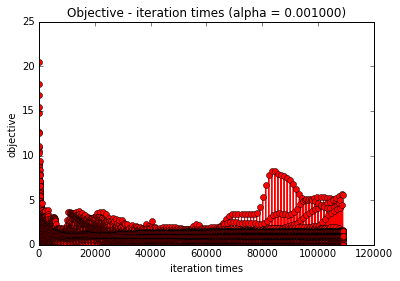

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 113.   10.    1.]
 [ 210.  377.  350.]
 [   9.    0.   19.]]
0.467401285583


test_c_matrix, test_accuracy_avg
[[ 109.   19.    0.]
 [ 244.  352.  344.]
 [   8.    1.   12.]]
0.434343434343


duration = 147.68479991
h =  450


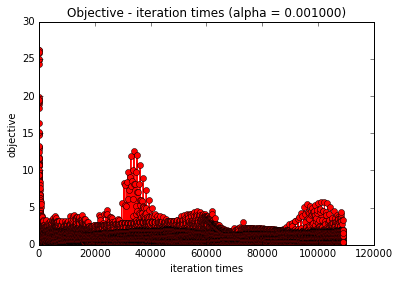

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 202.   17.    4.]
 [  66.  253.   26.]
 [  68.   90.  363.]]
0.751147842057


test_c_matrix, test_accuracy_avg
[[ 198.   19.    1.]
 [  62.  284.   20.]
 [  71.  116.  318.]]
0.734618916437


duration = 185.184112787


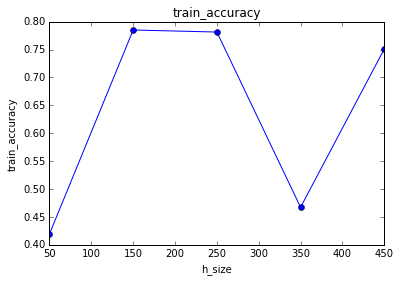

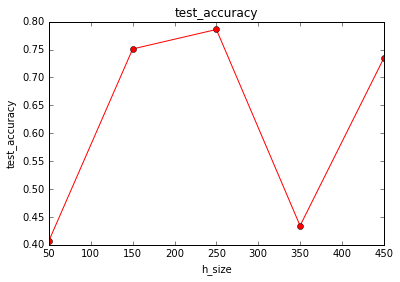

In [41]:
# V_1 = np.random.randn(h + 1, k)
# W_1 = np.random.randn(X.shape[1], h)

degree = 0
k = 3
h_size = [50, 150, 250, 350, 450]
alpha = 0.001
epsilon = 0
truncate = 0.05
n_folds = 5
max_iter = 100
r_verbose = True

train_accuracy = []
test_accuracy = []

for h in h_size:
    print 'h = ', h
    # start timing
    start = time.time()

    # cross validation
    tr_accuracy, t_accuracy = cross_validation2(X, y, degree, k, h, alpha, epsilon, \
                                                truncate=truncate, n_folds=n_folds, \
                                                max_iter=max_iter, r_verbose=r_verbose)

    # stop timing
    stop = time.time()
    duration = stop - start

    train_accuracy.append(tr_accuracy)
    test_accuracy.append(t_accuracy)

    print 'duration =', duration

plt.plot(h_size, train_accuracy, 'bo-')
plt.title('train_accuracy')
plt.xlabel('h_size')
plt.ylabel('train_accuracy')
plt.show()

plt.plot(h_size, test_accuracy, 'ro-')
plt.title('test_accuracy')
plt.xlabel('h_size')
plt.ylabel('test_accuracy')
plt.show()

alpha = 0.0001


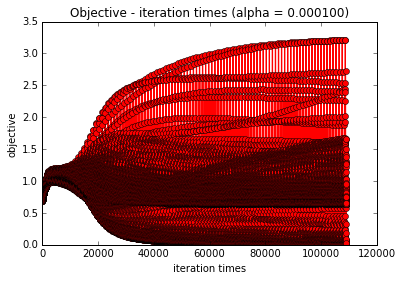

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 334.   34.  272.]
 [   9.  341.   30.]
 [  12.   19.   38.]]
0.654729109275


test_c_matrix, test_accuracy_avg
[[ 349.   27.  262.]
 [  10.  335.   35.]
 [  11.   22.   38.]]
0.662993572084


duration = 70.0622489452
alpha = 0.0005


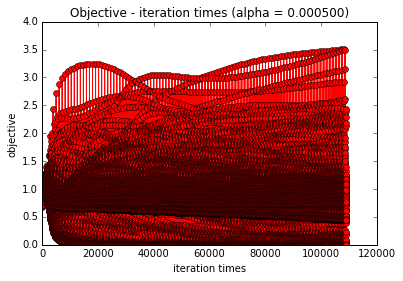

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 305.    1.  160.]
 [   1.  373.   18.]
 [  44.   25.  162.]]
0.771349862259


test_c_matrix, test_accuracy_avg
[[ 279.   12.  158.]
 [  18.  351.   59.]
 [  29.   29.  154.]]
0.719926538108


duration = 73.4702920914
alpha = 0.001


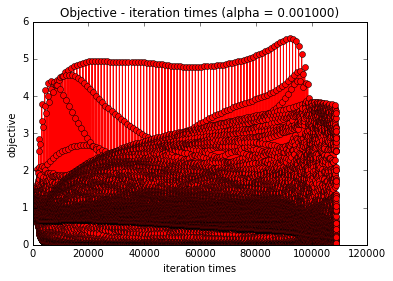

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 319.   13.   23.]
 [   0.  319.    7.]
 [  26.   43.  339.]]
0.897153351699


test_c_matrix, test_accuracy_avg
[[ 312.   16.   32.]
 [   1.  318.   20.]
 [  31.   37.  322.]]
0.87419651056


duration = 70.6242780685
alpha = 0.005


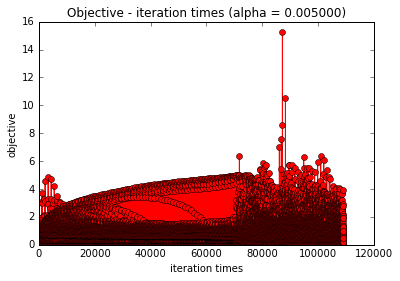

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 352.   38.   43.]
 [   6.  328.  124.]
 [   7.   20.  171.]]
0.78145087236


test_c_matrix, test_accuracy_avg
[[ 313.   35.   73.]
 [   8.  354.  105.]
 [  12.   15.  174.]]
0.772268135904


duration = 74.282954216
alpha = 0.01


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


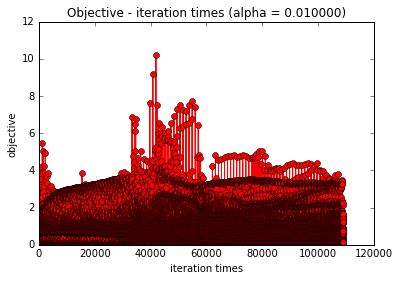

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 307.   14.   45.]
 [   3.  300.  126.]
 [  40.   79.  175.]]
0.718089990817


test_c_matrix, test_accuracy_avg
[[ 311.   18.   60.]
 [   1.  303.  104.]
 [  38.   87.  167.]]
0.717171717172


duration = 82.2632241249
alpha = 0.05


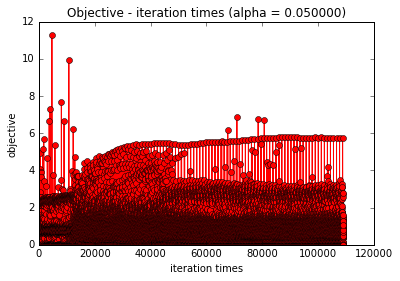

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 293.    3.    5.]
 [  23.  291.  206.]
 [  15.  102.  151.]]
0.674931129477


test_c_matrix, test_accuracy_avg
[[ 298.   13.   27.]
 [  33.  303.  212.]
 [  22.   75.  106.]]
0.649219467401


duration = 126.20865798
alpha = 0.1


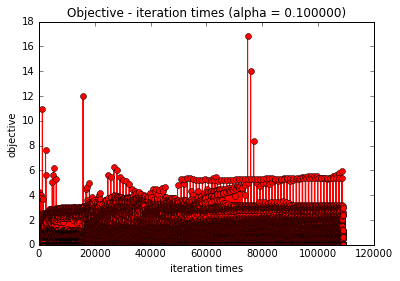

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 280.    1.   16.]
 [   0.  240.    4.]
 [  60.  168.  320.]]
0.771349862259


test_c_matrix, test_accuracy_avg
[[ 263.   10.   23.]
 [   0.  207.    2.]
 [  72.  165.  347.]]
0.750229568411


duration = 296.206312895
alpha = 0.5


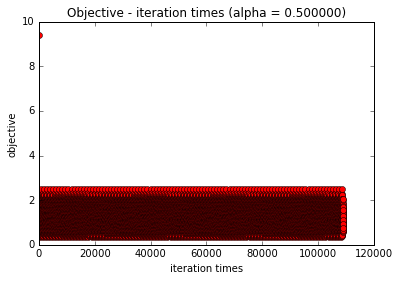

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 343.  408.  338.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
0.314967860422


test_c_matrix, test_accuracy_avg
[[ 324.  396.  369.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
0.297520661157


duration = 361.94956708


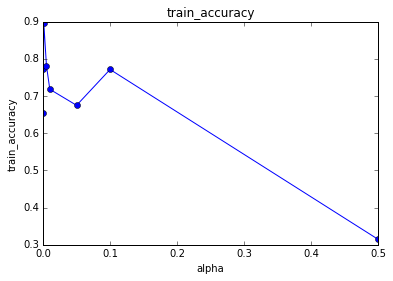

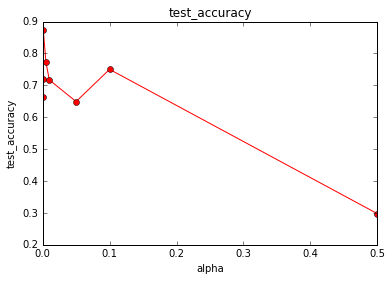

In [44]:
# V_1 = 1e-3 * np.random.randn(h + 1, k)
# W_1 = 1e-3 * np.random.randn(X.shape[1], h)

degree = 0
k = 3
h = 150
alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
epsilon = 0
truncate = 0.05

max_iter = 100
r_verbose = True

train_accuracy = []
test_accuracy = []

for a in alpha:
    print 'alpha =', a
    # start timing
    start = time.time()

    # cross validation
    tr_accuracy, t_accuracy = cross_validation2(X, y, degree, k, h, a, epsilon, \
                                                truncate=truncate, n_folds=n_folds, \
                                                max_iter=max_iter, r_verbose=r_verbose)
    
    # stop timing
    stop = time.time()
    duration = stop - start
    
    train_accuracy.append(tr_accuracy)
    test_accuracy.append(t_accuracy)

    print 'duration =', duration

plt.plot(alpha, train_accuracy, 'bo-')
plt.title('train_accuracy')
plt.xlabel('alpha')
plt.ylabel('train_accuracy')
plt.show()

plt.plot(alpha, test_accuracy, 'ro-')
plt.title('test_accuracy')
plt.xlabel('alpha')
plt.ylabel('test_accuracy')
plt.show()

h =  50


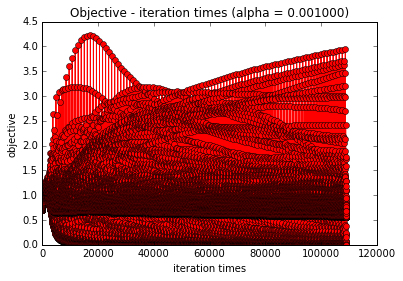

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 300.    1.  183.]
 [   2.  373.   17.]
 [  42.    6.  165.]]
0.769513314968


test_c_matrix, test_accuracy_avg
[[ 297.    6.  191.]
 [  17.  335.   43.]
 [  32.   35.  133.]]
0.702479338843


duration = 33.6841230392
h =  150


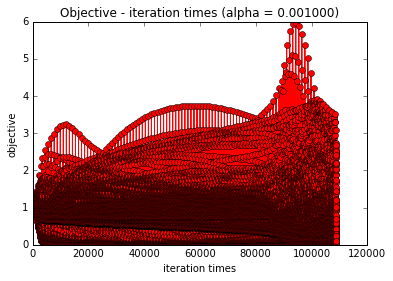

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 342.   11.   35.]
 [   1.  335.   11.]
 [  12.   47.  295.]]
0.892561983471


test_c_matrix, test_accuracy_avg
[[ 310.   20.   51.]
 [   3.  359.   25.]
 [  17.   51.  253.]]
0.846648301194


duration = 231.021751165
h =  250


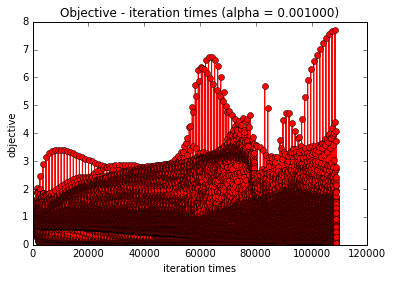

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 318.   11.   29.]
 [   0.  313.    8.]
 [  30.   58.  322.]]
0.875114784206


test_c_matrix, test_accuracy_avg
[[ 303.   13.   38.]
 [   1.  318.   19.]
 [  40.   49.  308.]]
0.853076216713


duration = 475.015764952
h =  350


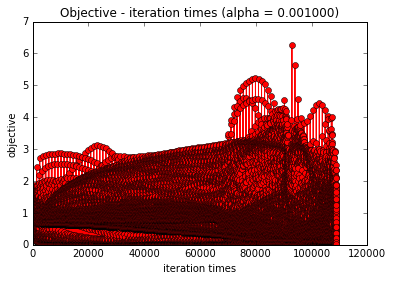

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 320.    5.   31.]
 [   0.  330.   11.]
 [  34.   65.  293.]]
0.86593204775


test_c_matrix, test_accuracy_avg
[[ 298.   16.   41.]
 [   4.  318.   13.]
 [  46.   65.  288.]]
0.830119375574


duration = 152.52790308
h =  450


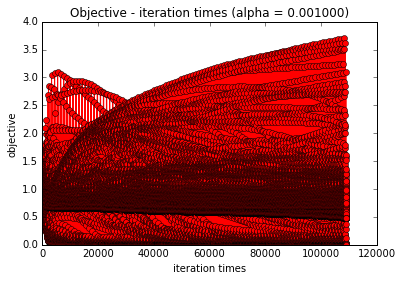

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 291.    4.  167.]
 [   0.  374.   12.]
 [  59.   10.  172.]]
0.768595041322


test_c_matrix, test_accuracy_avg
[[ 330.   14.  169.]
 [  17.  317.   31.]
 [  32.   35.  144.]]
0.726354453627


duration = 185.808176994


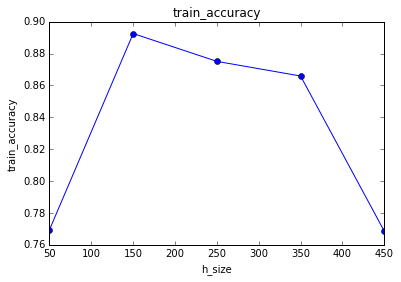

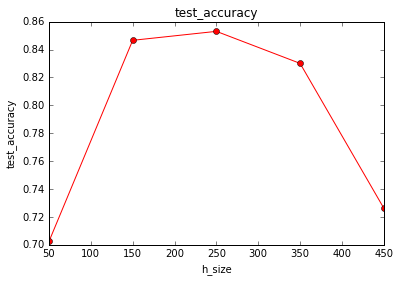

In [51]:
# V_1 = 1e-3 * np.random.randn(h + 1, k)
# W_1 = 1e-3 * np.random.randn(X.shape[1], h)

degree = 0
k = 3
h_size = [50, 150, 250, 350, 450]
alpha = 0.001
epsilon = 0
truncate = 0.05
n_folds = 5
max_iter = 100
r_verbose = True

train_accuracy = []
test_accuracy = []

for h in h_size:
    print 'h = ', h
    # start timing
    start = time.time()

    # cross validation
    tr_accuracy, t_accuracy = cross_validation2(X, y, degree, k, h, alpha, epsilon, \
                                                truncate=truncate, n_folds=n_folds, \
                                                max_iter=max_iter, r_verbose=r_verbose)

    # stop timing
    stop = time.time()
    duration = stop - start

    train_accuracy.append(tr_accuracy)
    test_accuracy.append(t_accuracy)

    print 'duration =', duration

plt.plot(h_size, train_accuracy, 'bo-')
plt.title('train_accuracy')
plt.xlabel('h_size')
plt.ylabel('train_accuracy')
plt.show()

plt.plot(h_size, test_accuracy, 'ro-')
plt.title('test_accuracy')
plt.xlabel('h_size')
plt.ylabel('test_accuracy')
plt.show()

alpha = 0.0001


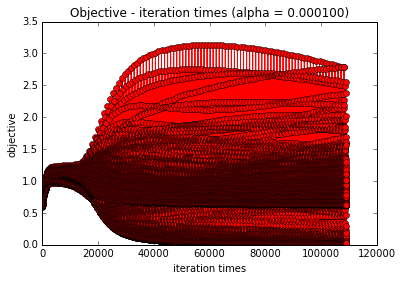

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 314.   11.  231.]
 [  15.  368.   41.]
 [  22.   23.   64.]]
0.685032139578


test_c_matrix, test_accuracy_avg
[[ 313.   19.  237.]
 [  19.  361.   55.]
 [  18.   22.   45.]]
0.660238751148


duration = 68.2977998257
alpha = 0.0005


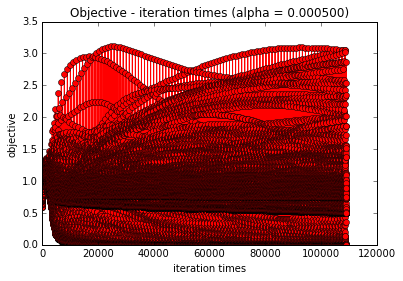

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 321.    5.  205.]
 [   1.  383.   16.]
 [  30.   21.  107.]]
0.744719926538


test_c_matrix, test_accuracy_avg
[[ 277.   11.  249.]
 [  17.  347.   48.]
 [  26.   33.   81.]]
0.64738292011


duration = 69.5060670376
alpha = 0.001


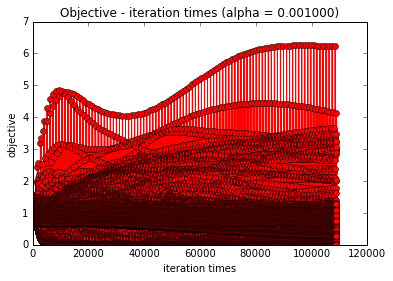

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 296.    6.   85.]
 [   0.  368.    8.]
 [  31.   19.  276.]]
0.863177226814


test_c_matrix, test_accuracy_avg
[[ 274.   15.  105.]
 [  21.  343.   54.]
 [  37.   36.  204.]]
0.753902662994


duration = 67.8763949871
alpha = 0.005


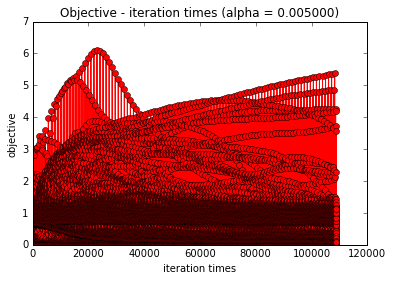

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 345.    2.  156.]
 [   0.  327.    1.]
 [   0.   50.  208.]]
0.808080808081


test_c_matrix, test_accuracy_avg
[[ 318.   24.  152.]
 [   6.  322.   31.]
 [  30.   53.  153.]]
0.728191000918


duration = 68.7223870754
alpha = 0.01


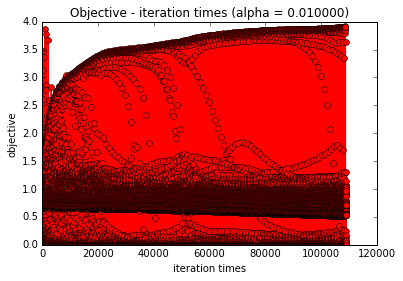

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 323.   15.  222.]
 [   0.  380.    3.]
 [  19.    3.  124.]]
0.759412304867


test_c_matrix, test_accuracy_avg
[[ 308.   26.  217.]
 [  10.  360.   47.]
 [  20.   19.   82.]]
0.68870523416


duration = 70.1335530281
alpha = 0.05


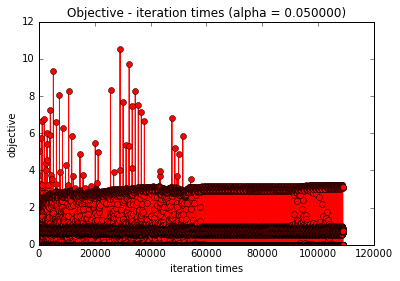

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 322.   33.  382.]
 [   0.  352.    0.]
 [   0.    0.    0.]]
0.618916437098


test_c_matrix, test_accuracy_avg
[[ 365.   55.  322.]
 [   9.  321.   17.]
 [   0.    0.    0.]]
0.629935720845


duration = 67.9825611115
alpha = 0.1


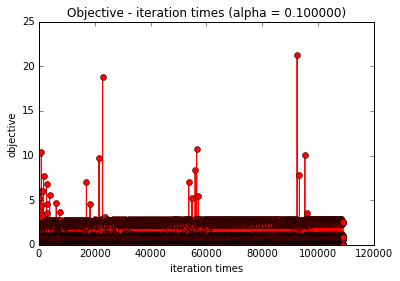

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[   0.    0.    0.]
 [   0.  385.    0.]
 [ 339.   55.  310.]]
0.638200183655


test_c_matrix, test_accuracy_avg
[[   0.    0.    0.]
 [   4.  341.   12.]
 [ 350.   53.  329.]]
0.615243342516


duration = 68.5761909485
alpha = 0.5


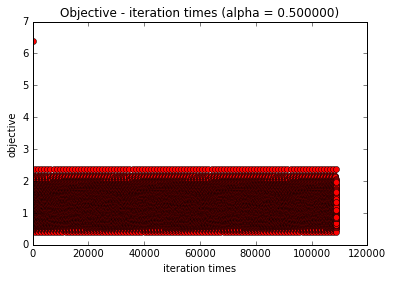

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[   0.    0.    0.]
 [ 346.  384.  359.]
 [   0.    0.    0.]]
0.35261707989


test_c_matrix, test_accuracy_avg
[[   0.    0.    0.]
 [ 345.  391.  353.]
 [   0.    0.    0.]]
0.359044995409


duration = 71.4141988754


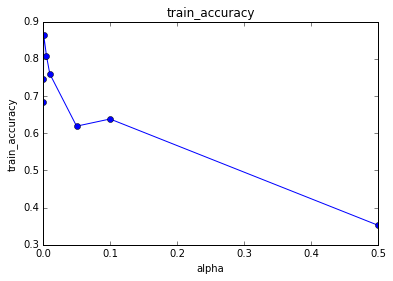

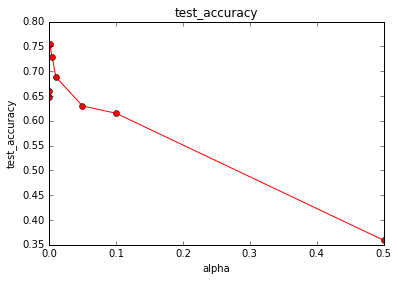

In [32]:
# V_1 = np.ones((h + 1, k)) * (np.sqrt(6) / (y.shape[0] + k))
# W_1 = np.ones((X.shape[1], h)) * (np.sqrt(6) / (y.shape[0] + k))

degree = 0
k = 3
h = 150
alpha = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
epsilon = 0
truncate = 0.05
n_folds = 5
max_iter = 100
r_verbose = True

train_accuracy = []
test_accuracy = []

for a in alpha:
    print 'alpha =', a
    # start timing
    start = time.time()

    # cross validation
    tr_accuracy, t_accuracy = cross_validation2(X, y, degree, k, h, a, epsilon, \
                                                truncate=truncate, n_folds=n_folds, \
                                                max_iter=max_iter, r_verbose=r_verbose)
    
    # stop timing
    stop = time.time()
    duration = stop - start
    
    train_accuracy.append(tr_accuracy)
    test_accuracy.append(t_accuracy)

    print 'duration =', duration

plt.plot(alpha, train_accuracy, 'bo-')
plt.title('train_accuracy')
plt.xlabel('alpha')
plt.ylabel('train_accuracy')
plt.show()

plt.plot(alpha, test_accuracy, 'ro-')
plt.title('test_accuracy')
plt.xlabel('alpha')
plt.ylabel('test_accuracy')
plt.show()

h =  50


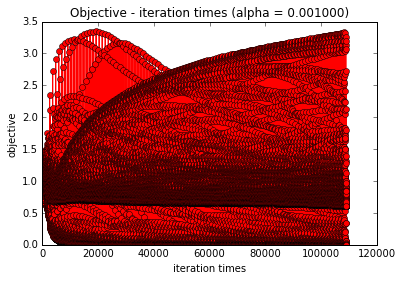

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 250.    7.  127.]
 [   0.  395.    3.]
 [  62.   22.  223.]]
0.797061524334


test_c_matrix, test_accuracy_avg
[[ 260.    3.  124.]
 [  18.  336.   29.]
 [  70.   56.  193.]]
0.724517906336


duration = 33.2812860012
h =  150


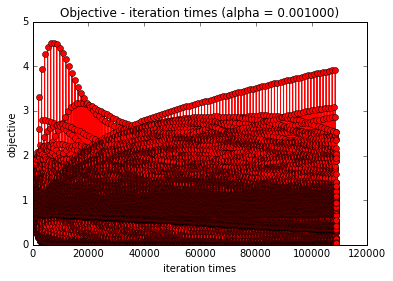

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 272.    1.   95.]
 [   0.  409.   21.]
 [  48.   16.  227.]]
0.833792470156


test_c_matrix, test_accuracy_avg
[[ 294.    7.  123.]
 [  11.  345.   54.]
 [  35.   32.  188.]]
0.759412304867


duration = 68.402711153
h =  250


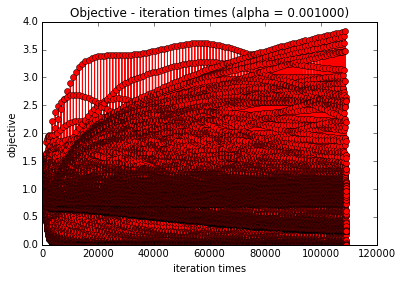

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 309.    5.  104.]
 [   0.  371.   15.]
 [  33.   20.  232.]]
0.837465564738


test_c_matrix, test_accuracy_avg
[[ 307.   14.  120.]
 [  18.  354.   35.]
 [  46.   39.  156.]]
0.750229568411


duration = 102.353688955
h =  350


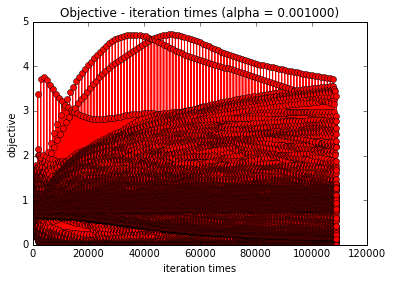

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 329.    9.   80.]
 [   0.  371.   11.]
 [  12.   31.  246.]]
0.868686868687


test_c_matrix, test_accuracy_avg
[[ 304.   19.  122.]
 [   7.  336.   41.]
 [  38.   39.  183.]]
0.755739210285


duration = 155.345889091
h =  450


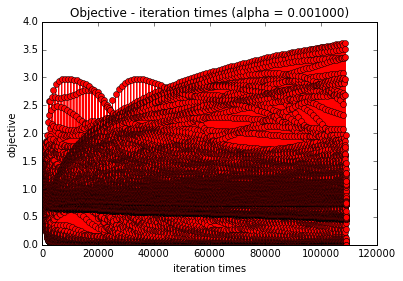

(average results) CROSS_VALIDATION (degree = 0) (k = 3) (n_folds = 5):
train_c_matrix, train_accuracy_avg
[[ 310.    6.  199.]
 [   1.  388.   17.]
 [  44.   13.  111.]]
0.742883379247


test_c_matrix, test_accuracy_avg
[[ 311.   17.  181.]
 [  25.  362.   34.]
 [  21.   26.  112.]]
0.720844811754


duration = 182.915128946


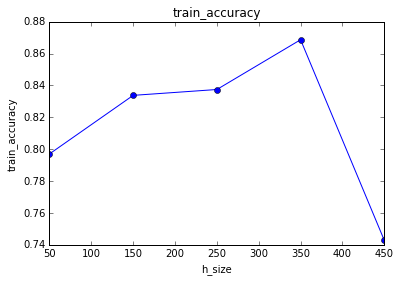

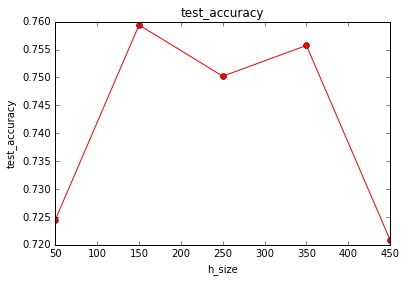

In [30]:
# V_1 = np.ones((h + 1, k)) * (np.sqrt(6) / (y.shape[0] + k))
# W_1 = np.ones((X.shape[1], h)) * (np.sqrt(6) / (y.shape[0] + k))

degree = 0
k = 3
h_size = [50, 150, 250, 350, 450]
alpha = 0.001
epsilon = 0
truncate = 0.05
n_folds = 5
max_iter = 100
r_verbose = True

train_accuracy = []
test_accuracy = []

for h in h_size:
    print 'h = ', h
    # start timing
    start = time.time()

    # cross validation
    tr_accuracy, t_accuracy = cross_validation2(X, y, degree, k, h, alpha, epsilon, \
                                                truncate=truncate, n_folds=n_folds, \
                                                max_iter=max_iter, r_verbose=r_verbose)

    # stop timing
    stop = time.time()
    duration = stop - start

    train_accuracy.append(tr_accuracy)
    test_accuracy.append(t_accuracy)

    print 'duration =', duration

plt.plot(h_size, train_accuracy, 'bo-')
plt.title('train_accuracy')
plt.xlabel('h_size')
plt.ylabel('train_accuracy')
plt.show()

plt.plot(h_size, test_accuracy, 'ro-')
plt.title('test_accuracy')
plt.xlabel('h_size')
plt.ylabel('test_accuracy')
plt.show()

Automatically created module for IPython interactive environment
Iteration 1, loss = 0.29942535
Iteration 2, loss = 0.13154932
Iteration 3, loss = 0.09428141
Iteration 4, loss = 0.07467230
Iteration 5, loss = 0.06056217
Iteration 6, loss = 0.05105381
Iteration 7, loss = 0.04240770
Iteration 8, loss = 0.03646686
Iteration 9, loss = 0.03011157
Iteration 10, loss = 0.02629163
Training set score: 0.994250
Test set score: 0.976100
duration = 8.38747692108


//anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:560: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


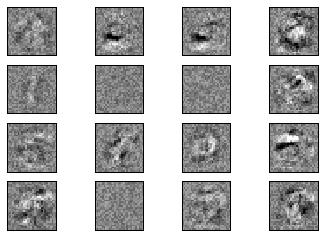

In [31]:
print(__doc__)

mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
s_X_all, s_y_all = mnist.data / 255., mnist.target
s_X_train, s_X_test = s_X_all[:60000], s_X_all[60000:]
s_y_train, s_y_test = s_y_all[:60000], s_y_all[60000:]

start = time.time()
# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, alpha=1e-4,
#                     algorithm='sgd', verbose=10, tol=1e-4, random_state=1)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10, alpha=1e-5,
                    algorithm='sgd', verbose=10, tol=1e-5, random_state=1,
                    learning_rate_init=.1)

mlp.fit(s_X_train, s_y_train)
print("Training set score: %f" % mlp.score(s_X_train, s_y_train))
print("Test set score: %f" % mlp.score(s_X_test, s_y_test))

# stop timing
stop = time.time()
duration = stop - start

print 'duration =', duration

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()